# Kalman Filter and State-Space Models

## Concepts

### 1) State-Space Models

Typically state-space models describe the relationship between some hidden (unknown) variables and their observed measurements.

State-space models goal is to infer the properties of the hidden variables given observed measurements. There are three main types of inference:

- **Filtering**: removing mesaurement error from the data when tyring to estimate the true value of the hidden variable from the observed variables

- **Forecasting**: predicting the future values of observed or hidden variables

- **Smoothing**: trying to estimate the past values of hidden variable from the measurements up to some future time

#### 1.1) Example 1 - Weighting the gold

In this example, we estimate the weight of the gold bar.The measurements don't have a systematic error, but the measurements do include random noise.

The system is the gold bar, and the system state is the weight of the gold bar. The dynamic model of the system is constant since we assume that the weight doesn't change over short periods.

To estimate the system state (i.e., the weight value), we can make multiple measurements and average them.

At the time $n$, the estimate $\hat{x}_{n,n}$ would be the average of all previous measurements:

\begin{align*}
\hat{x}_{n,n} = \tfrac{1}{n}\left(z_1+z_2 + \ldots + z_{n-1}+z_{n}\right) = \tfrac{1}{n} \sum_{i=1}^{n} z_i
\end{align*}

And we have the following notation:

<table>
    <tr>
        <td>$x$</td>
        <td>is the true value of the weight</td>
    </tr>
    <tr>
        <td>$z_n$</td>
        <td>is the measured value of the weight at time $n$</td>
    </tr>
    <tr>
        <td>$\hat{x}_{n,n}$</td>
        <td>is the estimate of $x$ at time $n$ (the estimate is made after taking the measurement $z_n$)</td>
    </tr>
    <tr>
        <td>$\hat{x}_{n+1,n}$</td>
        <td>is the estimate of the future state $(n+1)$ of $x$. The estimate is made at the time $n$. In other words, $\hat{x}_{n+1,n}$ is a predicted or extrapolated state</td>
    </tr>
    <tr>
        <td>$\hat{x}_{n-1,n}$</td>
        <td>is the estimate of $x$ at time $n−1$ (the estimate is made after taking the measurement $z_{n−1}$)</td>
    </tr>
    <tr>
        <td>$\hat{x}_{n-1,n-1}$</td>
        <td>is a prior prediction - the estimate of the state at time $n$. The prediction is made at the time $n−1$</td>
    </tr>
</table>

### 2) Kalman Filter

The Kalman Filter is a mathematical algorithm used for estimating the state of a system with uncertain measurements and dynamics. It consists of two main steps: the prediction step and the update step. Here are the equations for the Kalman Filter:

#### 2.1) Prediction Step
- State Prediction

$\hat{x}_{k}^{-} = F_{k}\hat{x}_{k-1} + B_{k}u_{k-1}$

- Error Covariance Prediction

$P_{k}^{-} = F_{k}P_{k-1}F_{k}^T + Q_{k}$

#### 2.2) Update Step

- Kalman Gain Calculation

$K_{k} = P_{k}^{-}H_{k}^T(HP_{k}^{-}H_{k}^T + R_{k})^{-1}$

- State Update

$\hat{x}_{k} = \hat{x}_{k}^{-} + K_{k}(y_{k} - H_{k}\hat{x}_{k}^{-})$

- Error Covariance Update

$P_{k} = (I - K_{k}H_{k})P_{k}^{-}$

Where:
\begin{align*}
\hat{x}_{k} & \text{ is the estimated state vector at time step } k. \\
\hat{x}_{k-1} & \text{ is the estimated state vector at the previous time step.} \\
F_{k} & \text{ is the state transition matrix from time step } k-1 \text{ to } k. \\
B_{k} & \text{ is the control-input matrix at time step } k. \\
u_{k-1} & \text{ is the control vector at time step } k-1. \\
P_{k} & \text{ is the error covariance matrix at time step } k. \\
Q_{k} & \text{ is the process noise covariance matrix at time step } k. \\
H_{k} & \text{ is the measurement matrix at time step } k. \\
y_{k} & \text{ is the measurement vector at time step } k. \\
R_{k} & \text{ is the measurement noise covariance matrix at time step } k. \\
K_{k} & \text{ is the Kalman Gain at time step } k. \\
I & \text{ is the identity matrix.} \\
\end{align*}

In [1]:
import numpy as np
import pandas as pd
import datetime as dt
import pickle
from glob import glob
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns

import scipy.stats as ss
from scipy.optimize import minimize

In [2]:
DATA_PATH = "Z:\Quant\Luiz\Studies\modelo de 2 fatores"

DATA_FILE = "wti_historical_prices.xlsx"

PRICES_SHEET_NAME = "Precos"

MATURITY_SHEET_NAME = "Maturidades"

In [3]:
file_path = os.path.join(DATA_PATH, DATA_FILE)

file_path

'Z:\\Quant\\Luiz\\Studies\\modelo de 2 fatores\\wti_historical_prices.xlsx'

In [4]:
price_df = pd.read_excel(file_path, sheet_name=PRICES_SHEET_NAME)

price_df.tail()

,Date,Price_M1,Date_M1,Price_M2,Date_M2,Price_M3,Date_M3,Price_M5,Date_M5,Price_M13,Date_M13,Price_M15,Date_M15,Price_M17,Date_M17,Price_M20,Date_M20,Price_M25,Date_M25
5915,2023-07-17,74.08,22/08/2023,73.89,22/08/2023,73.66,20/10/2023,73.11,19/12/2023,70.42,20/08/2024,69.83,22/10/2024,69.23,19/12/2024,68.37,20/03/2025,67.04,20/08/2025
5916,2023-07-18,75.66,22/08/2023,75.42,20/09/2023,75.14,20/10/2023,74.49,19/12/2023,71.61,20/08/2024,70.99,22/10/2024,70.35,19/12/2024,69.42,20/03/2025,68.02,20/08/2025
5917,2023-07-19,75.29,22/08/2023,75.11,20/09/2023,74.86,20/10/2023,74.27,19/12/2023,71.66,20/08/2024,71.09,22/10/2024,70.50,19/12/2024,69.63,20/03/2025,68.31,20/08/2025
5918,2023-07-20,75.65,22/08/2023,75.43,20/09/2023,75.16,20/10/2023,74.52,19/12/2023,71.84,20/08/2024,71.25,22/10/2024,70.63,19/12/2024,69.71,20/03/2025,68.35,20/08/2025
5919,2023-07-21,76.96,22/08/2023,76.64,20/09/2023,76.27,20/10/2023,75.45,19/12/2023,72.39,20/08/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
price_df.dtypes

Date         datetime64[ns]
Price_M1            float64
Date_M1              object
Price_M2            float64
Date_M2              object
Price_M3            float64
Date_M3              object
Price_M5            float64
Date_M5              object
Price_M13           float64
Date_M13             object
Price_M15           float64
Date_M15             object
Price_M17           float64
Date_M17             object
Price_M20           float64
Date_M20             object
Price_M25           float64
Date_M25             object
dtype: object

In [6]:
maturities_df = pd.read_excel(file_path, sheet_name=MATURITY_SHEET_NAME)

maturities_df

,Ticker,Expiration
0,CLF00 COMDTY,1999-12-20
1,CLG00 COMDTY,2000-01-20
2,CLH00 COMDTY,2000-02-22
3,CLJ00 COMDTY,2000-03-21
4,CLK00 COMDTY,2000-04-19
...,...,...
396,CLF33 COMDTY,2032-12-20
397,CLG33 COMDTY,2033-01-20
398,CLH33 COMDTY,2033-02-22
399,CLJ33 COMDTY,2033-03-22


In [7]:
nan_rows_df = price_df[price_df.isnull().any(axis=1)]

nan_rows_df

,Date,Price_M1,Date_M1,Price_M2,Date_M2,Price_M3,Date_M3,Price_M5,Date_M5,Price_M13,Date_M13,Price_M15,Date_M15,Price_M17,Date_M17,Price_M20,Date_M20,Price_M25,Date_M25
423,2001-09-11,141.61,20/09/2001,72.08,22/10/2001,37.56,19/11/2001,22.16,22/01/2002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1748,2007-01-02,309.79,22/01/2007,184.86,20/02/2007,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5919,2023-07-21,76.96,22/08/2023,76.64,20/09/2023,76.27,20/10/2023,75.45,19/12/2023,72.39,20/08/2024,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Como há poucas linhas como valores NaN, é razoável dar um _forward fill_ nelas.

In [8]:
price_df = price_df.ffill()

price_df.tail()

,Date,Price_M1,Date_M1,Price_M2,Date_M2,Price_M3,Date_M3,Price_M5,Date_M5,Price_M13,Date_M13,Price_M15,Date_M15,Price_M17,Date_M17,Price_M20,Date_M20,Price_M25,Date_M25
5915,2023-07-17,74.08,22/08/2023,73.89,22/08/2023,73.66,20/10/2023,73.11,19/12/2023,70.42,20/08/2024,69.83,22/10/2024,69.23,19/12/2024,68.37,20/03/2025,67.04,20/08/2025
5916,2023-07-18,75.66,22/08/2023,75.42,20/09/2023,75.14,20/10/2023,74.49,19/12/2023,71.61,20/08/2024,70.99,22/10/2024,70.35,19/12/2024,69.42,20/03/2025,68.02,20/08/2025
5917,2023-07-19,75.29,22/08/2023,75.11,20/09/2023,74.86,20/10/2023,74.27,19/12/2023,71.66,20/08/2024,71.09,22/10/2024,70.50,19/12/2024,69.63,20/03/2025,68.31,20/08/2025
5918,2023-07-20,75.65,22/08/2023,75.43,20/09/2023,75.16,20/10/2023,74.52,19/12/2023,71.84,20/08/2024,71.25,22/10/2024,70.63,19/12/2024,69.71,20/03/2025,68.35,20/08/2025
5919,2023-07-21,76.96,22/08/2023,76.64,20/09/2023,76.27,20/10/2023,75.45,19/12/2023,72.39,20/08/2024,71.25,22/10/2024,70.63,19/12/2024,69.71,20/03/2025,68.35,20/08/2025


In [9]:
def get_tenor_expiration_date(current_date: dt.date, expiration_list: list, tenor_index: int) -> dt.date:
    """
    Given the current or trade date, a list of maturity dates of all tenors and tenor that is looking for, this method returns the tenor maturity date for that current or trade date.
    
    Input:
      current_date [datetime.date object] - Date reference to get a respective tenor maturity date
      maturity_list [datetime.date object] - List containing all possible maturities
      tenor_index [int object] - Tenor to get its maturity, for example, 3 for third tenor for a given current_date

    Output:
      maturity_date [datetime.date object] - Maturity date for a tenor given the current date.
    """
    
    expiration_index = 0
    
    for index, expiration_date in enumerate(expiration_list):
        if current_date <= expiration_date:
            expiration_index = index
            break
    
    expiration_index += (tenor_index - 1)
    
    expiration = expiration_list[expiration_index]
    
    return expiration

In [10]:
def get_business_days_between_dates(start_date: dt.date, end_date: dt.date,) -> int:
    """
    Given start and end dates, this method retuns the amount of business days betweend those dates.
    
    Input:
      start_date [datetime.date object] - Start date.
      end_date [datetime.date object] - End date.

    Output:
      business_days [int object] - Amount of business days betweend start and end dates.
    """
    
    formated_start_date = start_date.strftime('%Y-%m-%d')
    
    formated_end_date = end_date.strftime('%Y-%m-%d')
    
    business_days = np.busday_count(formated_start_date, formated_end_date)
    
    return int(business_days)

In [11]:
def numpy_datetime_to_datetime(date):
    """
    Converts a numpy datetime64 object to a python datetime object 
    Input:
      date - a np.datetime64 object
    Output:
      DATE - a python date object
    """
    
    timestamp = ((date - np.datetime64('1970-01-01T00:00:00'))
                 / np.timedelta64(1, 's'))
    
    return dt.datetime.utcfromtimestamp(timestamp)

In [12]:
maturity_columns = [column for column in list(price_df.columns) if str(column).startswith("Date")]

maturity_columns

['Date',
 'Date_M1',
 'Date_M2',
 'Date_M3',
 'Date_M5',
 'Date_M13',
 'Date_M15',
 'Date_M17',
 'Date_M20',
 'Date_M25']

In [13]:
for column in maturity_columns:
    price_df[column] = pd.to_datetime(price_df[column])

price_df.dtypes

Date         datetime64[ns]
Price_M1            float64
Date_M1      datetime64[ns]
Price_M2            float64
Date_M2      datetime64[ns]
Price_M3            float64
Date_M3      datetime64[ns]
Price_M5            float64
Date_M5      datetime64[ns]
Price_M13           float64
Date_M13     datetime64[ns]
Price_M15           float64
Date_M15     datetime64[ns]
Price_M17           float64
Date_M17     datetime64[ns]
Price_M20           float64
Date_M20     datetime64[ns]
Price_M25           float64
Date_M25     datetime64[ns]
dtype: object

In [14]:
price_columns = [column for column in list(price_df.columns) if str(column).startswith("Price")]

price_columns = ["Date"] + price_columns

price_columns

['Date',
 'Price_M1',
 'Price_M2',
 'Price_M3',
 'Price_M5',
 'Price_M13',
 'Price_M15',
 'Price_M17',
 'Price_M20',
 'Price_M25']

In [15]:
tenor_list = [int(tenor.split("_M")[1]) for tenor in price_columns if str(tenor).startswith("Price_")]

tenor_list

[1, 2, 3, 5, 13, 15, 17, 20, 25]

Getting $T_i - t$

In [16]:
for column in maturity_columns:
    if column == "Date":
        continue
    
    maturity = str(column).split("_")[1]
    
    delta_t_column_name = f"Delta_t_{maturity}"
    
    price_df[delta_t_column_name] = price_df.apply(lambda trade: get_business_days_between_dates(trade["Date"], trade[column])/252, axis=1)
                                                
price_df

,Date,Price_M1,Date_M1,Price_M2,Date_M2,Price_M3,Date_M3,Price_M5,Date_M5,Price_M13,...,Date_M25,Delta_t_M1,Delta_t_M2,Delta_t_M3,Delta_t_M5,Delta_t_M13,Delta_t_M15,Delta_t_M17,Delta_t_M20,Delta_t_M25
0,2000-01-04,79.99,2000-01-20,46.20,2000-02-22,23.71,2000-03-21,13.77,2000-05-22,9.51,...,2002-01-22,0.047619,0.138889,0.218254,0.392857,1.087302,1.250000,1.428571,1.686508,2.123016
1,2000-01-05,77.99,2000-01-20,45.14,2000-02-22,23.20,2000-03-21,13.54,2000-05-22,9.36,...,2002-01-22,0.043651,0.134921,0.214286,0.388889,1.083333,1.246032,1.424603,1.682540,2.119048
2,2000-01-06,77.58,2000-01-20,45.01,2000-02-22,23.13,2000-03-21,13.49,2000-05-22,9.32,...,2002-01-22,0.039683,0.130952,0.210317,0.384921,1.079365,1.242063,1.420635,1.678571,2.115079
3,2000-01-07,75.83,2000-01-20,44.19,2000-02-22,22.85,2000-03-21,13.45,2000-05-22,9.39,...,2002-01-22,0.035714,0.126984,0.206349,0.380952,1.075397,1.238095,1.416667,1.674603,2.111111
4,2000-01-10,77.23,2000-01-20,44.88,2000-02-22,23.21,2000-03-21,13.67,2000-05-22,9.55,...,2002-02-20,0.031746,0.123016,0.202381,0.376984,1.071429,1.325397,1.412698,1.757937,2.190476
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5915,2023-07-17,74.08,2023-08-22,73.89,2023-08-22,73.66,2023-10-20,73.11,2023-12-19,70.42,...,2025-08-20,0.103175,0.103175,0.273810,0.440476,1.134921,1.313492,1.480159,1.738095,2.170635
5916,2023-07-18,75.66,2023-08-22,75.42,2023-09-20,75.14,2023-10-20,74.49,2023-12-19,71.61,...,2025-08-20,0.099206,0.182540,0.269841,0.436508,1.130952,1.309524,1.476190,1.734127,2.166667
5917,2023-07-19,75.29,2023-08-22,75.11,2023-09-20,74.86,2023-10-20,74.27,2023-12-19,71.66,...,2025-08-20,0.095238,0.178571,0.265873,0.432540,1.126984,1.305556,1.472222,1.730159,2.162698
5918,2023-07-20,75.65,2023-08-22,75.43,2023-09-20,75.16,2023-10-20,74.52,2023-12-19,71.84,...,2025-08-20,0.091270,0.174603,0.261905,0.428571,1.123016,1.301587,1.468254,1.726190,2.158730


In [17]:
delta_t_columns = [column for column in list(price_df.columns) if str(column).startswith("Delta")]

delta_t_columns

['Delta_t_M1',
 'Delta_t_M2',
 'Delta_t_M3',
 'Delta_t_M5',
 'Delta_t_M13',
 'Delta_t_M15',
 'Delta_t_M17',
 'Delta_t_M20',
 'Delta_t_M25']

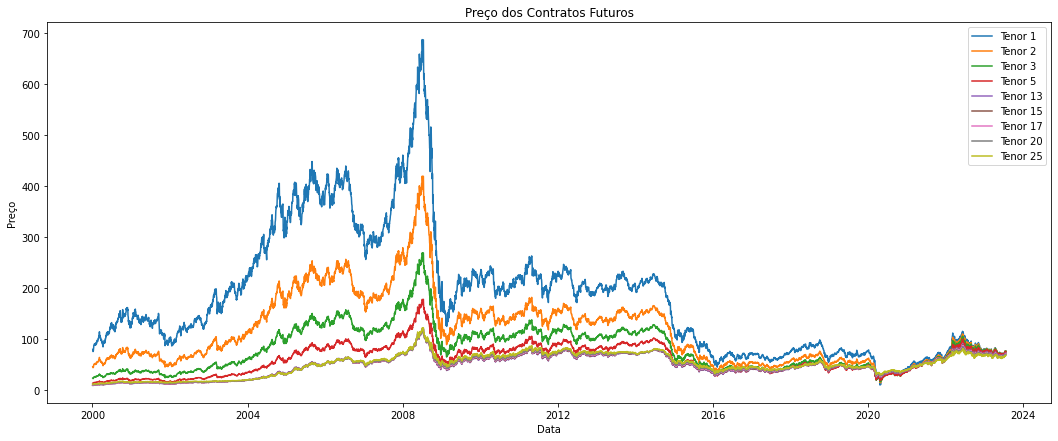

In [18]:
%matplotlib inline

fig = plt.figure(figsize=(18, 7))

for column in price_columns[1:]:
    if str(column).startswith("Price"):
        column_label = column.split("_M")[1]

        tenor_label = f"Tenor {column_label}"

        plt.plot(
            price_df["Date"],
            price_df[column],
            label = tenor_label
        )

plt.title("Preço dos Contratos Futuros")

plt.xlabel("Data")
plt.ylabel("Preço")

plt.legend()

#
plt.show();
#

## Representação em Espaço de Estados Modelo de 1 Fator

### Brennan e Schwartz (1985)

Modelo de 1 fator de Brennan e Schwartz (1985), que considera a dinâmica do preço à vista $S_t$ de um movimento geométrico Browniano, portanto, sob a MMM $Q$, temos

\begin{align*}
dS_t = (\theta - y_c)S_tdt + \sigma S_td \tilde{B}_t
\end{align*}

onde $y_c$ é o retorno de conveniência, $\theta$ é o _drift_ e $\sigma$ a volatilidade.

Para o uso do Filtro de Kalman é necessária a representação das equações do algoritmo.

### Equação de Transição

Umas das equações do Filtro de Kalman é a equação de transição, responsável pela atualização das variáveis dos estados latentes. Assumindo $X_t = \ln S_t$, temos que a dinâmica de $X_t$ será dada por

\begin{align*}
dX_t = (\theta - \frac{1}{2}\sigma^2 - y_c)dt + \sigma d\tilde{B}_t
\end{align*}

Para o nosso problema, quando discretizamos a EDE da dinâmica de $X_t = \ln S_t$, ficamos com a seguinte equação matricial, que será a Equação de Transição do Filtro de Kalman

\begin{align*}
\begin{bmatrix}
\ln S_{t}
\end{bmatrix}
=
\begin{bmatrix}
\ln S_{t-1}
\end{bmatrix}
+
\begin{bmatrix}
(\theta - \frac{1}{2}\sigma^2 - y_c) \Delta t
\end{bmatrix}
+
\eta_{t}
\end{align*}

Com $\eta_t \sim NID \ (0, \mathbb{T})$ sendo um vetor de perturbações sem correlação serial e com média e variância dados por

\begin{align*}
\mathbb{E}[\eta_{t}] =
\begin{bmatrix}
0
\end{bmatrix} \ \ \ \ \ \
\text{e} \ \ \ \ \ \
Var[\eta_{t}]=
\begin{bmatrix}
\sigma^2 \Delta t
\end{bmatrix}
\end{align*}

### Equação de Medição

Outra equação importante para o uso do Filtro de Kalman é a equação de medição, responsável por relacionar as variáveis de estados latentes com os valores que observamos, no nosso caso, os preços dos futuros para alguns vencimentos.

\begin{align*}
\begin{bmatrix}
\ln(F_1) \\
\ln(F_2) \\
\vdots \\
\ln(F_N) \\
\end{bmatrix}
=
\begin{bmatrix}
B(T_1) \\
B(T_2) \\
\vdots\\
B(T_N) \\
\end{bmatrix}
\begin{bmatrix}
\ln S_{t}
\end{bmatrix}
+
\begin{bmatrix}
A(T_1) \\
A(T_2) \\
\vdots \\
A(T_N) \\
\end{bmatrix}
+
\epsilon_t
\end{align*}

Onde $N$ é o número de maturidades do contrato da _commodity_ que se deseja analisar. Além disso, temos que

\begin{align*}
A(T_i) &= (\theta - y_c)(T_i-t) \\
B(T_i) &= 1
\end{align*}

E $\epsilon_t$ é um vetor $N \times 1$ de perturbações sem correlação serial com
\begin{align*}
\mathbb{E}[\epsilon_{t}] =
\begin{bmatrix}
0
\end{bmatrix} \ \ \ \ \ \
\text{e} \ \ \ \ \ \
Var[\epsilon_{t}]=
\begin{bmatrix}
\phi_1^2 & 0 & 0 & \ldots & 0 \\
0 & \phi_2^2 & 0 & \ldots & 0 \\
0 & 0 & \phi_3^2 & \ldots & 0 \\
\vdots & \vdots & \vdots & \ddots & \vdots \\
0 & 0 & 0 & \ldots & \phi_N^2 \\
\end{bmatrix}
\end{align*}

Essa equação de medição nasce de um resultado derivado do modelo para o _log_ dos preços futuros, cuja equação para o preço num instante $t$ de um futuro com vencimento em $T$, ou seja, o preço dado por $F_{t,T}$, é dado por

\begin{align*}
\ln[F_{t,T}(X_t, t)] = \ln S_t + (\mu - y) (T-t)
\end{align*}

Dadas todas essas equações, o Filtro de Kalman busca estimar todos os parâmetros $\Theta = \{ \kappa, \ \sigma, \ \delta, \ \theta, \ \phi_1, \ \phi_2, \ \ldots, \ \phi_N] \}$.

### Log-verossimilhança

A equação da log-verossimilhança é dada por
\begin{align*}
\ln(L) = \sum_t (-\frac{n}{2}\ln(2\pi) - \frac{1}{2}\ln(det(F_{t|t-1})) - \frac{1}{2}v_t^T F_{t|t-1}^{-1}v_t)
\end{align*}

In [19]:
def KalmanFilter(Y, F, H, Q, R, C, D, x0, P0):
    # Number of iterations
    n = len(Y)

    # Number of states
    m = F.shape[0]

    # Initializing state mean and covariance arrays
    x_hat = np.ones((n, m, 1))
    x_hat_minus = np.ones((n, m, 1))

    P_minus_t = np.zeros((n, m, m))
    P = np.zeros((n, m, m))

    p = Y.shape[1]

    F_t = np.zeros((n, p, p))
    
    # Setting first elements
    x_hat[0] = x0
    x_hat_minus[0] = x0
    P[0] = P0
    P_minus_t[0] = P0
    F_t[0] = R
    
    # Log-likelihood
    log_likelihood = -n/2 * np.log(2 * np.pi)

    # Kalman filter iterations
    for iteration in range(1, n):
        # Predict
        x_hat_minus[iteration] = F@x_hat[iteration - 1] + C
        # x_hat_minus = x_hat_minus.reshape(m,m)
        
        P_minus = np.array(F@P[iteration - 1]@F.T + Q)
        P_minus = P_minus.reshape((m, m))
        P_minus_t[iteration] = P_minus
        #########

        # Update log-likelihood
        # Innovation
        eta_t = Y[iteration].reshape(p, 1) - np.dot(H[iteration], x_hat_minus[iteration]) - D[iteration]
        # print(f"iteration {iteration}")
        # print("x_hat_minus[iteration]")
        # print(x_hat_minus[iteration])
        # print("-" * 10)
        # print("H[iteration]")
        # print(H[iteration])
        # print("-" * 10)
        # print("x_hat_minus")
        # print(x_hat_minus)
        # print("-" * 10)
        # print("np.dot(H[iteration], x_hat_minus)")
        # print(np.dot(H[iteration], x_hat_minus))
        # print("-" * 10)
        # print("D[iteration]")
        # print(D[iteration])
        # print("-" * 10)
        # print(eta_t)
        # print("-" * 45)

        # Innovation covariance
        F_t[iteration] = np.dot(H[iteration], np.dot(P_minus_t[iteration], H[iteration].T)) + R
        covariance_determinant = np.linalg.det(F_t[iteration])
        if abs(covariance_determinant) == 0 or str(covariance_determinant).lower() == "nan":
            # print(f"iteration {iteration}")
            # print("x_hat_minus[iteration]")
            # print(x_hat_minus[iteration])
            # print("-" * 10)
            # print("H[iteration]")
            # print(H[iteration])
            # print("-" * 10)
            # print("x_hat_minus[iteration]")
            # print(x_hat_minus[iteration])
            # print("-" * 10)
            # print("np.dot(H[iteration], x_hat_minus)")
            # print(np.dot(H[iteration], x_hat_minus))
            # print("-" * 10)
            # print("D[iteration]")
            # print(D[iteration])
            # print("-" * 10)
            # print(eta_t)
            # print("-" * 45)
            return -1e10, x_hat_minus, x_hat, P
        
        log_like = (np.log(np.linalg.det(F_t[iteration])) + np.dot(eta_t.T, np.dot(np.linalg.inv(F_t[iteration]), eta_t)))
        log_likelihood -= 0.5 * log_like[0][0]

        # Update
        Kalman_gain = P_minus_t[iteration] @ H[iteration].T @ np.linalg.inv(F_t[iteration])
        x_hat[iteration] = x_hat_minus[iteration] + Kalman_gain@(Y[iteration].reshape(p, 1) - H[iteration]@x_hat_minus[iteration] - D[iteration])
        P[iteration] = P_minus_t[iteration] - Kalman_gain@H[iteration]@P_minus_t[iteration]

    return log_likelihood, x_hat_minus, x_hat, P

def KalmanSmoother(Y, F, H, Q, R, C, D, x0, P0):
    # Run the forward pass
    log_likelihood, x_hat_minus, x_hat, P = KalmanFilter(Y, F, H, Q, R, C, D, x0, P0)

    n = len(Y)
    m = F.shape[0]

    # Initializing smoothed state means and covariances
    x_hat_smooth = np.zeros((n, m, 1))
    P_smooth = np.zeros((n, m, m))

    x_hat_smooth[-1] = x_hat[-1]
    P_smooth[-1] = P[-1]
    
    # Kalman smoother iterations (backward)
    for k in range(n - 2, -1, -1):
        if m == 1:
            inverse = np.array(1 / (F@P[k]@F.T + Q)).reshape(m,m)
        else:
            inverse = np.linalg.inv(F@P[k]@F.T + Q)
        J = P[k]@F.T@inverse
        x_hat_smooth[k] = x_hat[k] + J@(x_hat_smooth[k + 1] - F@x_hat[k])
        P_smooth[k] = P[k] + J@(P_smooth[k + 1] - F@P[k]@F.T + Q - P[k])@J.T

    return log_likelihood, x_hat_smooth, x_hat_minus, x_hat, P_smooth

### Testing Kalman Filter

In [20]:
fut_prices_df = price_df[price_columns[1:]]

log_fut_prices = np.array(np.log(fut_prices_df))

log_fut_prices.shape

(5920, 9)

In [21]:
delta_T_t_df = price_df[delta_t_columns]

delta_T_t = np.array(delta_T_t_df)

delta_T_t.shape

(5920, 9)

In [22]:
delta_t = 1/52

theta = 0.0
y = 0.00375518
sigma = 0.0036151
variance_list = [0.01] * len(fut_prices_df.columns)

A_T = (theta - y) * delta_T_t
A_T = A_T.reshape((A_T.shape[0], A_T.shape[1], 1))

B_T = np.ones(A_T.shape)

H = np.array(B_T)
D = np.array(A_T)

F = np.array([1])
C = np.ones((F.shape[0],)) * (theta - 0.5 * (sigma ** 2) - y) * delta_t
Q = np.array([sigma ** 2])

R = np.diag(variance_list)

x0 = np.ones((F.shape[0],))
x_0 = log_fut_prices[0][0]
x0[0] = x_0

P0 = np.eye(F.shape[0])

# log_likelihood, x_hat_minus, x_hat, P = KalmanFilter(log_fut_prices, F, H, Q, R, C, D, x0, P0)
log_likelihood, x_hat_smooth, x_hat_minus, x_hat, P_smooth = KalmanSmoother(log_fut_prices, F, H, Q, R, C, D, x0, P0)

print(f"Log Likelihood is {log_likelihood}")

Log Likelihood is -557016.1292289299


Em uma iteração do Filtro de Kalman já podemos verificar a curva do preço _spot_ encontrada.

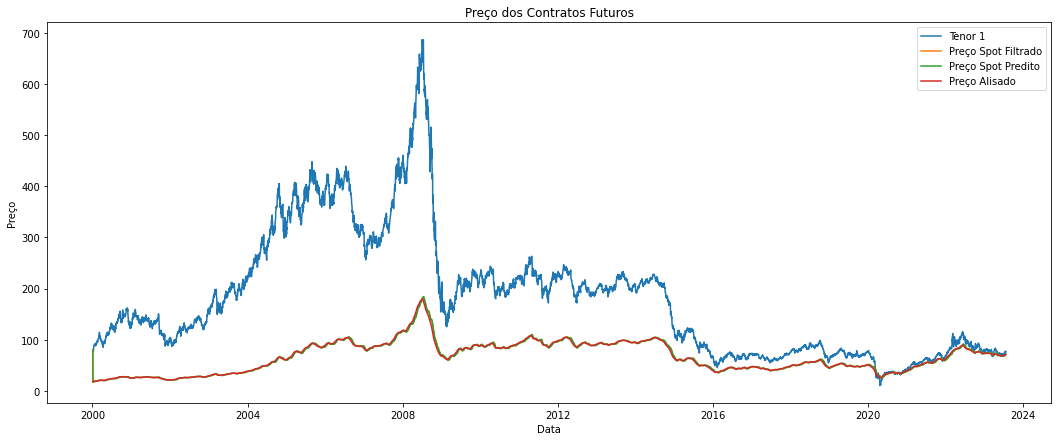

In [23]:
%matplotlib inline

fig = plt.figure(figsize=(18, 7))
    
plt.plot(
    price_df["Date"],
    price_df["Price_M1"],
    label = "Tenor 1"
)

plt.plot(
    price_df["Date"],
    np.exp(x_hat).reshape(len(x_hat_minus)),
    label = "Preço Spot Filtrado"
)

plt.plot(
    price_df["Date"],
    np.exp(x_hat_minus).reshape(len(x_hat_minus)),
    label = "Preço Spot Predito"
)

plt.plot(
    price_df["Date"],
    np.exp(x_hat_smooth).reshape(len(x_hat_smooth)),
    label = "Preço Alisado"
)

plt.title("Preço dos Contratos Futuros")

plt.xlabel("Data")
plt.ylabel("Preço")

plt.legend()

#
plt.show();
#

### Maximizing Log Likelihood

#### Parameters initial guess

Getting best inicial guesses for this 1 factor model.

This guessing was the first when there wasn't any.

In [34]:
beta, alpha, _, _, stderr = ss.linregress(log_fut_prices.T[0][1:], log_fut_prices.T[0][:-1])

In [35]:
tenor_quantity = len(fut_prices_df.columns)

sigma_0 = stderr/np.sqrt(delta_t)

theta_minus_y_c = alpha + 0.5 * (sigma_0 ** 2)

theta_0 = 0.0
y_0 = theta_minus_y_c - theta_0
variance_list = [0.01] * tenor_quantity

parameters_list = [theta_0, y_0, sigma_0]

parameters_list.extend(variance_list)

parameters_array = np.array(parameters_list)

parameters_array

array([0.        , 0.00375518, 0.0036151 , 0.01      , 0.01      ,
       0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
       0.01      , 0.01      ])

If we run the maximization of Log Likelihood we will check the following best parameters approximately

In [151]:
parameters_array = np.array([-0.08, 0.08, 0.02, 0.9, 0.5, 0.1, 0.0001, 0.05, 0.05, 0.05, 0.05, 0.05])

parameters_array

array([-8.e-02,  8.e-02,  2.e-02,  9.e-01,  5.e-01,  1.e-01,  1.e-04,
        5.e-02,  5.e-02,  5.e-02,  5.e-02,  5.e-02])

In [141]:
def minus_likelihood_one_factor_kalman_filter(parameters_list, log_fut_prices):
    """ Returns the negative log-likelihood """

    theta = parameters_list[0]
    y = parameters_list[1]
    sigma = parameters_list[2]
    variance_list = parameters_list[3:]

    A_T = (theta - y) * delta_T_t
    A_T = A_T.reshape((A_T.shape[0], A_T.shape[1], 1))

    B_T = np.ones(A_T.shape)

    H = np.array(B_T)
    D = np.array(A_T)

    F = np.array([1])
    C = np.ones((F.shape[0],)) * (theta - 0.5 * (sigma ** 2) - y) * delta_t
    Q = np.array([sigma ** 2])

    R = np.diag(variance_list)

    x0 = np.ones((F.shape[0],))
    x_0 = log_fut_prices[0][0]
    x0[0] = x_0

    P0 = np.eye(F.shape[0])

    loglik, _, _, _ = KalmanFilter(log_fut_prices, F, H, Q, R, C, D, x0, P0)

    return -loglik

parameters = [parameters_array]

def callback_function(xk):
    print("Iteration:", callback_function.iteration)
    print("Loss function value:", minus_likelihood_one_factor_kalman_filter(xk, log_fut_prices))
    print("Optimized parameters:", xk)
    print("-" * 85)
    callback_function.iteration += 1
    
    global parameters
    
    parameters.append(xk)

In [142]:
theta_bounds = (None, None)
y_c_bounds =(None, None)
sigma_bounds = (0.0001, None)
variances_bounds = [(0.0001, None)] * tenor_quantity

bounds_=[theta_bounds, y_c_bounds, sigma_bounds]
bounds_.extend(variances_bounds)

bounds_

[(None, None),
 (None, None),
 (0.0001, None),
 (0.0001, None),
 (0.0001, None),
 (0.0001, None),
 (0.0001, None),
 (0.0001, None),
 (0.0001, None),
 (0.0001, None),
 (0.0001, None),
 (0.0001, None)]

In [153]:
options = {'maxiter': 200}

callback_function.iteration = 1

result = minimize(
    minus_likelihood_one_factor_kalman_filter,
    x0 = parameters_array,
    args = (log_fut_prices,),
    callback = callback_function,
    method = "L-BFGS-B",
    bounds = bounds_,
    tol = 1e-6,
    options = options,
)

Iteration: 1
Loss function value: -43601.14503900054
Optimized parameters: [-8.34806778e-02  8.34806706e-02  1.99999674e-02  9.01966574e-01
  4.99999180e-01  1.00024883e-01  1.00000000e-04  4.99999182e-02
  4.99999182e-02  4.99999182e-02  4.99999182e-02  6.31710454e-02]
-------------------------------------------------------------------------------------
Iteration: 2
Loss function value: -43633.9967278454
Optimized parameters: [-8.30425796e-02  8.30425735e-02  1.89474097e-02  9.01725742e-01
  4.99990772e-01  1.00016405e-01  1.00000000e-04  4.99321428e-02
  4.98253461e-02  4.97974822e-02  4.97772659e-02  6.12750342e-02]
-------------------------------------------------------------------------------------
Iteration: 3
Loss function value: -43645.81430023969
Optimized parameters: [-8.27129117e-02  8.27129063e-02  1.76029302e-02  9.01548108e-01
  4.99979915e-01  1.00007185e-01  1.00000000e-04  4.98451161e-02
  4.96011548e-02  4.95374949e-02  4.94912924e-02  5.97217103e-02]
----------------

In [154]:
print(result)

      fun: -43646.494603107414
 hess_inv: <12x12 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 1.40208867e+03, -1.40206976e+03, -3.65895903e+03, -1.17496965e+03,
        2.67633004e+02,  1.42100180e+02,  1.23237900e+06,  1.94511158e+03,
        5.12928964e+03,  5.98810729e+03,  6.65273983e+03,  8.99475708e+02])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 104
      nit: 5
     njev: 8
   status: 0
  success: True
        x: array([-8.28454016e-02,  8.28453959e-02,  1.78354049e-02,  9.01621576e-01,
        4.99981699e-01,  1.00009276e-01,  1.00000000e-04,  4.98596045e-02,
        4.96384507e-02,  4.95807356e-02,  4.95388378e-02,  6.02741322e-02])


In [155]:
hessian_matrix = result.hess_inv.todense()

hessian_df = pd.DataFrame(hessian_matrix)

hessian_df

,0,1,2,3,4,5,6,7,8,9,10,11
0,79.227379,-78.227209,-161.505516,-43.172572,-1.290697,-1.376863,8.834996,-10.396998,-26.833639,-31.131130,-34.269274,-332.449728
1,-78.227209,79.227039,161.505165,43.172478,1.290694,1.376860,-8.834976,10.396975,26.833580,31.131062,34.269200,332.449005
2,-161.505516,161.505165,334.271770,89.118892,2.666244,2.852682,-18.282864,21.528553,55.456700,64.309660,70.734286,686.801050
3,-43.172572,43.172478,89.118892,24.826507,0.712188,0.759732,-4.875361,5.736600,14.806286,17.177742,18.909700,183.468132
4,-1.290697,1.290694,2.666244,0.712188,1.021331,0.022813,-0.145871,0.172240,0.443672,0.514495,0.565887,5.489375
5,-1.376863,1.376860,2.852682,0.759732,0.022813,1.024340,-0.156082,0.184020,0.474394,0.550224,0.605393,5.856061
6,8.834996,-8.834976,-18.282864,-4.875361,-0.145871,-0.156082,1.000000,-1.178034,-3.034432,-3.518792,-3.870240,-37.572805
7,-10.396998,10.396975,21.528553,5.736600,0.172240,0.184020,-1.178034,2.390687,3.582351,4.154227,4.569238,44.229932
8,-26.833639,26.833580,55.456700,14.806286,0.443672,0.474394,-3.034432,3.582351,10.227986,10.701115,11.770167,114.128979
9,-31.131130,31.131062,64.309660,17.177742,0.514495,0.550224,-3.518792,4.154227,10.701115,13.409410,13.649123,132.400596


In [156]:
result.x

array([-8.28454016e-02,  8.28453959e-02,  1.78354049e-02,  9.01621576e-01,
        4.99981699e-01,  1.00009276e-01,  1.00000000e-04,  4.98596045e-02,
        4.96384507e-02,  4.95807356e-02,  4.95388378e-02,  6.02741322e-02])

In [135]:
# In case connection is lost

parameters_result = np.array([-8.27250351e-02,  8.64806760e-02,  1.80953498e-02,  9.72458726e-01,
        4.90983159e-01,  1.02005462e-01,  1.00000000e-04,  4.77557889e-02,
        4.50769935e-02,  4.46645442e-02,  4.43757667e-02,  6.06442481e-02])

parameters_result

array([-8.27250351e-02,  8.64806760e-02,  1.80953498e-02,  9.72458726e-01,
        4.90983159e-01,  1.02005462e-01,  1.00000000e-04,  4.77557889e-02,
        4.50769935e-02,  4.46645442e-02,  4.43757667e-02,  6.06442481e-02])

In [116]:
parameters

[array([0.        , 0.00375518, 0.0036151 , 0.01      , 0.01      ,
        0.01      , 0.01      , 0.01      , 0.01      , 0.01      ,
        0.01      , 0.01      ]),
 array([-0.03510225,  0.03885741,  0.0350131 ,  0.92476114,  0.33095977,
         0.05458355,  0.01356253,  0.1233718 ,  0.12217012,  0.12033351,
         0.11080178,  0.09352572]),
 array([-3.87697516e-02,  4.25249145e-02,  3.26666555e-02,  9.24934258e-01,
         3.31357148e-01,  5.89279529e-02,  1.00000000e-04,  1.22471212e-01,
         1.21204360e-01,  1.19302817e-01,  1.09581281e-01,  9.19655966e-02]),
 array([-4.39001661e-02,  4.76553315e-02,  1.86838858e-02,  9.25139110e-01,
         3.32011847e-01,  6.46186301e-02,  1.00000000e-04,  1.20887672e-01,
         1.19545823e-01,  1.17572396e-01,  1.07606302e-01,  8.96601236e-02]),
 array([-4.49663743e-02,  4.87215403e-02,  1.58859858e-02,  9.25177958e-01,
         3.32147355e-01,  6.57910622e-02,  1.00000000e-04,  1.20554765e-01,
         1.19197102e-01,  1.17208570

In [157]:
delta_t = 1/52

theta = result.x[0]
y = result.x[1]
sigma = result.x[2]
variance_list = result.x[3:]

# theta = parameters_result[0]
# y = parameters_result[1]
# sigma = parameters_result[2]
# variance_list = parameters_result[3:]

A_T = (theta - y) * delta_T_t
A_T = A_T.reshape((A_T.shape[0], A_T.shape[1], 1))

B_T = np.ones(A_T.shape)

H = np.array(B_T)
D = np.array(A_T)

F = np.array([1])
C = np.ones((F.shape[0],)) * (theta - 0.5 * (sigma ** 2) - y) * delta_t
Q = np.array([sigma ** 2])

R = np.diag(variance_list)

x0 = np.ones((F.shape[0],))
x_0 = log_fut_prices[0][0]
x0[0] = x_0

P0 = np.eye(F.shape[0])

log_likelihood, x_hat_smooth, x_hat_minus, x_hat, P_smooth = KalmanSmoother(log_fut_prices, F, H, Q, R, C, D, x0, P0)

print(f"Log Likelihood is {log_likelihood}")

Log Likelihood is 43646.494603107414


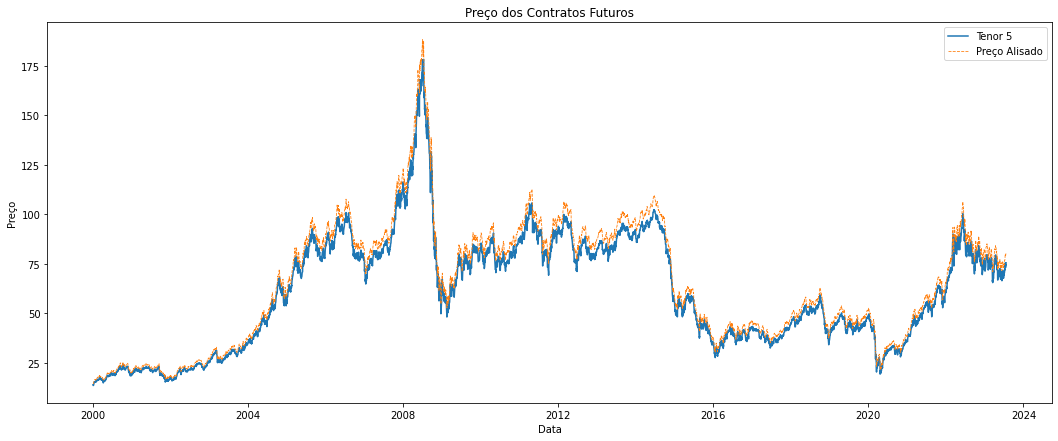

In [158]:
%matplotlib inline

fig = plt.figure(figsize=(18, 7))
    
plt.plot(
    price_df["Date"],
    price_df["Price_M5"],
    label = "Tenor 5"
)

plt.plot(
    price_df["Date"],
    np.exp(x_hat_smooth).reshape(len(x_hat_smooth)),
    label = "Preço Alisado",
    linestyle="--",
    linewidth= 0.8
)

plt.title("Preço dos Contratos Futuros")

plt.xlabel("Data")
plt.ylabel("Preço")

plt.legend()

#
plt.show();
#

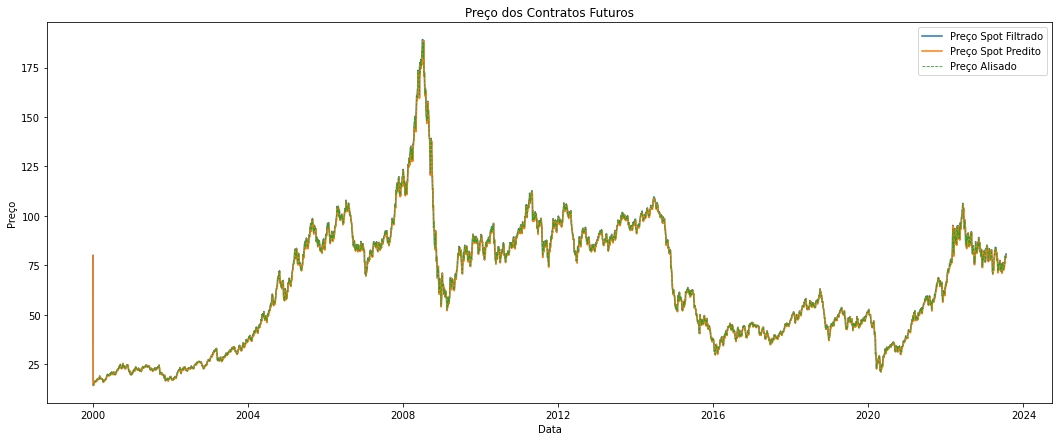

In [159]:
%matplotlib inline

fig = plt.figure(figsize=(18, 7))
    
plt.plot(
    price_df["Date"],
    np.exp(x_hat).reshape(len(x_hat_minus)),
    label = "Preço Spot Filtrado"
)

plt.plot(
    price_df["Date"],
    np.exp(x_hat_minus).reshape(len(x_hat_minus)),
    label = "Preço Spot Predito"
)

plt.plot(
    price_df["Date"],
    np.exp(x_hat_smooth).reshape(len(x_hat_smooth)),
    label = "Preço Alisado",
    linestyle="--",
    linewidth= 0.8
)

plt.title("Preço dos Contratos Futuros")

plt.xlabel("Data")
plt.ylabel("Preço")

plt.legend()

#
plt.show();
#

In [133]:
d = 252

futures = [column for column in list(price_df.columns) if column.startswith("Price_") ]

vol_fut_wti_dict = {
    "Futuro": [],
    "Volatilidade": [],
}

for fut in futures:
    vol = price_df[fut].pct_change().std() * (d ** 0.5)
    
    future = fut.split("_")[1]

    vol_fut_wti_dict["Futuro"].append(future)
    vol_fut_wti_dict["Volatilidade"].append(vol)

vol_fut_wti_df = pd.DataFrame(vol_fut_wti_dict)

vol_fut_wti_df

,Futuro,Volatilidade
0,M1,0.413943
1,M2,0.376966
2,M3,0.357408
3,M5,0.331017
4,M13,0.274946
5,M15,0.266411
6,M17,0.258903
7,M20,0.249097
8,M25,0.236413


In [138]:
volatility_term_estructure = sigma * np.exp(- theta * delta_T_t) * (d ** 0.5)

volatility_term_estructure

array([[0.28838858, 0.29057424, 0.29248828, ..., 0.32328948, 0.33026189,
        0.34240563],
       [0.28829393, 0.29047887, 0.29239228, ..., 0.32318337, 0.3301535 ,
        0.34229325],
       [0.2881993 , 0.29038353, 0.29229631, ..., 0.3230773 , 0.33004513,
        0.3421809 ],
       ...,
       [0.28952687, 0.29152969, 0.29364275, ..., 0.324459  , 0.33145663,
        0.34353151],
       [0.28943184, 0.29143401, 0.29354637, ..., 0.3243525 , 0.33134784,
        0.34341875],
       [0.28933684, 0.29133835, 0.29345002, ..., 0.32424604, 0.33123908,
        0.34330604]])

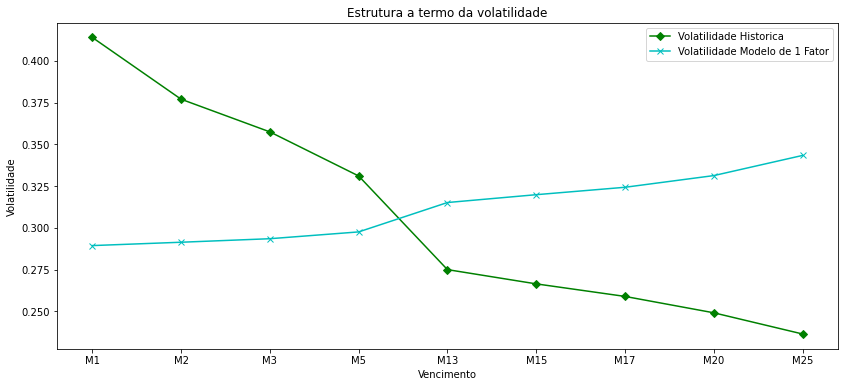

In [140]:
%matplotlib inline

fig = plt.figure(figsize=(14, 6))

plt.plot(
    vol_fut_wti_df["Futuro"],
    vol_fut_wti_df["Volatilidade"],
    color = 'g',
    marker = 'D',
    label = "Volatilidade Historica"
)

plt.plot(
    vol_fut_wti_df["Futuro"],
    volatility_term_estructure[-1],
    color = 'c',
    marker = 'x',
    label = "Volatilidade Modelo de 1 Fator"
)

plt.title("Estrutura a termo da volatilidade")
plt.legend()
plt.xlabel("Vencimento")
plt.ylabel("Volatilidade")

#
plt.show();
#